# Costruction of a broad dataset on pumps and dumps
## Filtering using sample parameters

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import feather
import os
import glob
import time
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

In [6]:
# import the generated list of all tickers for which we have the data:
with open("tickers_list_total.txt", "r") as fp:
    tickers_list_total = json.load(fp)
all_tickers = tickers_list_total[0]
len(all_tickers)

8248

### Convert slow .csv aggregated files by timeframes to .feather format

In [ ]:
def create_1m_feather(all_tickers):
    parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m'
    for i in tqdm(range(len(all_tickers))):
        ticker_name = all_tickers[i]
        file_min = os.path.join(parent_dir_min, ticker_name + '.csv')
        df_min = pd.read_csv(file_min).sort_values(by='time', ascending=True)
        
        df_min['times'] = pd.to_datetime(df_min['time'])
        df_min['date'] = pd.to_datetime(df_min['times'].dt.date)
        df_min['time'] = df_min['times'].dt.time
        mask = df_min[['date', 'time', 'open', 'high', 'low', 'close', 'volume']]
        mask.set_index('date', inplace=True)
        
        parent_dir_train = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
        mask.reset_index().to_feather(os.path.join(parent_dir_train, ticker_name + '.feather'))

In [ ]:
create_1m_feather(train_list)

In [ ]:
def create_15m_feather(all_tickers):
    parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_15m'
    for i in tqdm(range(len(all_tickers))):
        ticker_name = all_tickers[i]
        file_min = os.path.join(parent_dir_min, ticker_name + '.csv')
        df_min = pd.read_csv(file_min).sort_values(by='time', ascending=True)
        
        df_min['times'] = pd.to_datetime(df_min['time'])
        df_min['date'] = pd.to_datetime(df_min['times'].dt.date)
        df_min['time'] = df_min['times'].dt.time
        mask = df_min[['date', 'time', 'open', 'high', 'low', 'close', 'volume']]
        mask.set_index('date', inplace=True)
        
        parent_dir_train = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_15m_feather'
        mask.reset_index().to_feather(os.path.join(parent_dir_train, ticker_name + '.feather'))

In [352]:
create_15m_feather(all_tickers)

100%|██████████████████████████████████████████████████████████████████| 8248/8248 [03:36<00:00, 38.11it/s]


In [ ]:
### daily_adj_feather
def create_daily_adj_feather(all_tickers):
    for i in tqdm(range(len(all_tickers))):
        ticker_name = all_tickers[i]
        parent_dir_min = os.path.join('C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj', ticker_name)
        file_min = os.path.join(parent_dir_min, ticker_name + '_daily_adj' + '.csv')
        df_min = pd.read_csv(file_min, header=0, names = ['date','open','high','low','close','adj close','volume','dividend amount','split coefficient'])
        
        df_min['date'] = pd.to_datetime(df_min['date'])
        df_min.sort_values(by='date', ascending=True, inplace=True)
        df_min.set_index('date', inplace=True)
        df_min = df_min[['open', 'high', 'low', 'close', 'volume']]
        
        parent_dir_train = 'C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj_feather'
        df_min.reset_index().to_feather(os.path.join(parent_dir_train, ticker_name + '.feather'))

In [4]:
create_daily_adj_feather(all_tickers)

100%|██████████████████████████████████████████████████████████████████████████████| 8248/8248 [02:27<00:00, 56.01it/s]


### Let's consider the distribution of candle prints, which can tell us what is the minimal number of prints to take

In [7]:
all_liquid_obs = []
for i in tqdm(range(len(all_tickers))):
    ticker_name = all_tickers[i]  
    parent_dir_one_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
    file_one_min = os.path.join(parent_dir_one_min, ticker_name + '.feather') 
    df_one_min = pd.read_feather(file_one_min) 
    counts = df_one_min.groupby(['date']).count().iloc[:,0].reset_index()
    counts = counts[(counts['date'] >= '2019-09-03') & (counts['date'] <= '2021-08-06')]
    counts.date = counts.date.astype(str)
    all_counts = counts.values.tolist()
    all_liquid_obs.append([ticker_name, all_counts])

100%|██████████████████████████████████████████████████████████████████████████████| 8248/8248 [04:20<00:00, 31.69it/s]


In [ ]:
#with open('all_liquid_obs.txt', 'w') as fp:
#    json.dump(all_liquid_obs, fp)

In [3]:
with open("all_liquid_obs.txt", "r") as fp:
    all_liquid_obs = json.load(fp)

In [8]:
# find the dates in which there were any trading sessions
all_liquid_sessions = []
for ticker in all_liquid_obs:
    liquid_day = []
    for day in ticker[1]:
        if day[1] >= 0: 
            liquid_day.append(day[0])
    all_liquid_sessions.append([ticker[0], liquid_day])

In [11]:
# consider the distribution of observations by the number of prints:
all_sessions = []
for ticker in all_liquid_obs:
    for day in ticker[1]:
        all_sessions.append(day[1])

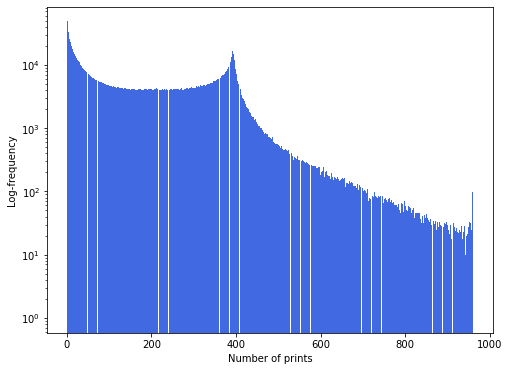

In [31]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(all_sessions, bins=1000, log=True, color ='royalblue')
plt.xlabel('Number of prints')
plt.ylabel('Log-frequency')
plt.show()

In [32]:
# that spike is:
opt_prints = bins[np.where(n == n[200:].max())][0]
opt_prints

391.71999999999997

### Consider the distribution of returns in order to understand what minimum returns should be applied to extract the pumps or dumps

In [58]:
def get_all_pnd(all_liquid_sessions):
    all_pnd = []
    for i in tqdm(range(len(all_liquid_sessions))):
        ticker_name = all_liquid_sessions[i][0]
        days = all_liquid_sessions[i][1]
        parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
        file_min = os.path.join(parent_dir_min, ticker_name + '.feather')
        df_min = pd.read_feather(file_min)
        
        per_ticker_list = []
        for day in days:
            mask = df_min[df_min['date'] == day]
            min_ser = mask.to_numpy()
            if min_ser.size > 0:
                # find max and min for all ohlc data
                max_price = np.max(min_ser[:,2:6])
                min_price = np.min(min_ser[:,2:6])
                
                # daily price range and day_ret yield, this is how pumps and dumps may differ from simple movements

                day_range = max_price - min_price
                day_ret = max_price/min_price - 1 
                
                # find max_coverage, coverage of the daily price movement,
                # the closer to 100%, the more likely it is one or few long candles, i.e. a sharp pump
                if day_range > 0:
                    all_coverage = []
                    hl = min_ser[:,3:5].astype(np.float32)
                    for i in range(hl.shape[0]):
                        perf_min = hl[i][0] - hl[i][1]
                        coverage = perf_min/day_range
                        all_coverage.append(coverage)
                    max_coverage = max(all_coverage)
                    per_ticker_list.append([day, day_ret, max_coverage])
        all_pnd.append([ticker_name, per_ticker_list])
    return all_pnd

In [37]:
all_pnd = get_all_pnd(all_liquid_sessions)

100%|██████████████████████████████████████████████████████████████████████████████| 8248/8248 [07:44<00:00, 17.76it/s]


In [ ]:
#with open('all_pnd3.txt', 'w') as fp:
#    json.dump(all_pnd, fp)

In [33]:
with open("all_pnd3.txt", "r") as fp:
    all_pnd = json.load(fp)

In [34]:
# convert to the format: ticker, day, daily growth, price range coverage
all_pnd_sessions = []
for ticker in all_pnd:
    for day in ticker[1]:
        all_pnd_sessions.append([ticker[0], day[0], day[1], day[2]])

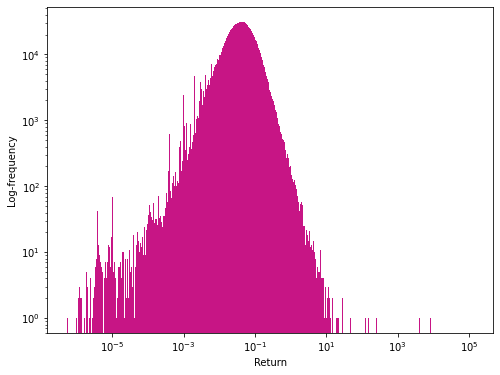

In [37]:
# let's take a look for the return distribution:
all_pnd_sessions_df = pd.DataFrame(all_pnd_sessions, columns =['ticker','date','High-Low range', '1m candle coverage'])
plt.figure(figsize=(8,6))
hist, bins = np.histogram(all_pnd_sessions_df['High-Low range'], bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(all_pnd_sessions_df['High-Low range'], bins=logbins, log=True, color ='mediumvioletred')
plt.xscale('log')
plt.xlabel('Return')
plt.ylabel('Log-frequency')
plt.show()

In [60]:
hist, bins = np.histogram(all_pnd_sessions_df['High-Low range'], bins=1000)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
hist, new_bins = np.histogram(all_pnd_sessions_df['High-Low range'], bins=logbins)
new_bins[np.where(hist == hist.max())[0]]

array([0.04135757])

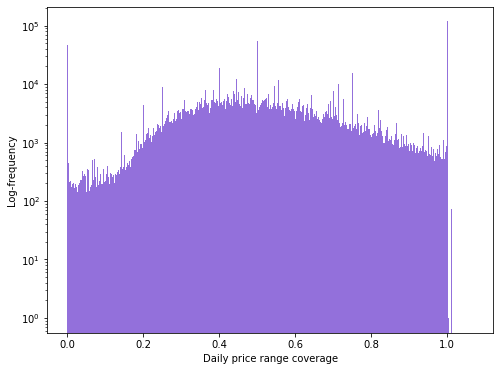

In [38]:
# let's take a look for the daily price range coverage:
plt.figure(figsize=(8,6))
plt.hist(all_pnd_sessions_df['1m candle coverage'], bins=1000, log=True, color ='mediumpurple')
#plt.xscale('log')
plt.xlabel('Daily price range coverage')
plt.ylabel('Log-frequency')
plt.show()

### Let's also consider the overall positive or negative movement of intraday prices, because it is assumed that most of the pump and dump movements occur mainly above the daily open price.

In [52]:
def get_all_spikes(all_pnd):
    for i in tqdm(range(len(all_pnd))):
        ticker_name = all_pnd[i][0]
        days = [x[0] for x in all_pnd[i][1]]
        parent_dir_min = 'C:/Users/Kuanysh/Downloads/pump_and_dump/agg_tickers_1m_feather'
        file_min = os.path.join(parent_dir_min, ticker_name + '.feather')
        df_min = pd.read_feather(file_min)
        df_min = df_min.sort_values(by='time', ascending=True)
       
        for j in range(len(days)):
            mask = df_min[df_min['date'] == days[j]]
            min_ser = mask.to_numpy()
            first_open = min_ser[0][2]
            close_sums = 0
            for k in range(len(min_ser)):
                close = min_ser[k][5]
                if close > first_open:
                    close_sums+=1
            pos_neg_coverage = close_sums/len(min_ser)
            all_pnd[i][1][j].extend([pos_neg_coverage, len(min_ser)])  
    return all_pnd

In [53]:
all_spikes = get_all_spikes(all_pnd)

100%|██████████████████████████████████████████████████████████████████████████████| 8248/8248 [55:39<00:00,  2.47it/s]


In [54]:
#with open('all_spikes_1m.txt', 'w') as fp:
#    json.dump(all_spikes, fp)

In [50]:
with open("all_spikes_1m.txt", "r") as fp:
    all_spikes = json.load(fp)

In [55]:
# add more descriptive features: positive or negative coverage and the number of prints
all_spikes_sessions = []
for ticker in all_spikes:
    for day in ticker[1]:
        all_spikes_sessions.append([ticker[0], day[0], day[1], day[2], day[3], day[4]])

### Construct the broad dataset:

In [56]:
df_pn = pd.DataFrame(all_spikes_sessions, columns =['ticker','date','High-Low range', '15m candle coverage', 'pos_neg_coverage', 'number of prints'])
df_pn = df_pn.sort_values(by=['High-Low range', '15m candle coverage','pos_neg_coverage','number of prints'], ascending=[False, False, False, False])
df_pn

,ticker,date,High-Low range,15m candle coverage,pos_neg_coverage,number of prints
1031604,GCMG,2020-12-16,1.286990e+05,0.943279,0.013405,373
2687364,XBIOW,2019-11-08,8.138000e+03,0.458098,1.000000,5
2415051,THWWW,2020-03-25,3.999000e+03,0.742686,0.000000,3
2733675,ZVZZT,2019-11-11,2.308000e+03,0.562392,0.034483,261
2733672,ZVZZT,2019-11-06,1.300000e+03,0.614615,0.005208,192
...,...,...,...,...,...,...
1716216,NMK-P-B,2021-01-29,1.000000e-06,0.991821,1.000000,1
1716249,NMK-P-B,2021-08-04,9.975062e-07,0.991821,0.000000,1
1716372,NMK-P-C,2021-07-14,9.523819e-07,0.991821,0.000000,1
1323604,ITIC,2021-03-30,5.989821e-07,0.915527,1.000000,1


In [68]:
# Let's filter them by profitability and by the number of prints:
new_df_pn = df_pn[(df_pn['High-Low range']>0.1) & (df_pn['number of prints']>300)].sort_values(by=['High-Low range', '15m candle coverage'], ascending=[False, False])
new_df_pn

,ticker,date,High-Low range,15m candle coverage,pos_neg_coverage,number of prints
347137,GCMG,2020-12-16,128699.000000,0.943279,0.013405,373
753250,SPI,2020-09-23,41.816514,0.452172,1.000000,655
359195,GLSI,2020-12-09,28.272222,0.233707,1.000000,413
62194,APM,2020-09-29,21.416667,0.896357,1.000000,771
27155,AGBAR,2021-03-30,21.193548,0.995434,0.996983,663
...,...,...,...,...,...,...
897501,WWR,2021-06-07,0.100000,0.232558,0.987981,416
688849,RIG,2021-06-21,0.100000,0.230770,0.985714,560
21249,AEG,2020-03-11,0.100000,0.200000,0.019851,403
691915,RLGY,2021-01-21,0.100000,0.179267,0.996960,329


In [69]:
#new_df_pn.to_csv('train_data_10_pct2.csv')

In [72]:
with open('train_list_10_pct2.txt', 'w') as fp:
    json.dump(train_list, fp)